# How to train an ontology-based variational autoencoder (Ontix)

In normal autoencoders, latent dimensions are not explainable by design. To gain explainability and incorporate biological information, a popular approach is to restrict the decoder of the autoencoder to match feature connectivity, such as an ontology. 

**IMPORTANT**

> This tutorial only shows the specifics of the Ontix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` Tutorial first.

## What You'll Learn

In this notebook we will show two types of ontologies and how they can be used to train an explainable variational autoencoder, `Ontix`. 
The first is based on biological pathways from the Reactome database (left), and the second uses chromosomal location of genes (right) as a showcase. 

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/5dabc4a697cbba74d3f6144dc4b6d0fd6df2b624/images/ontix_scheme.svg" alt="ontix-ontologies" width="1200"/>

You’ll learn how to:

1. **Initialize** the pipeline, ontologies, and run Ontix with **chromosomal ontologies**. <br><br>
2. **Initialize** the pipeline, ontologies, and run Ontix with **Reactome pathways**. <br><br>
3. **Evaluate** Ontix on downstream tasks. <br><br>

By working with these examples, we will also cover on the go:  <br><br>
- Understand the Ontix-specific **pipeline steps**. <br><br>
- Access the Ontix-specific **results** (mu, sigma, KL/MMD losses). <br><br>
- **Visualize** outputs effectively. <br><br>
- Apply **custom parameters**. <br><br>
- **Save, load, and reuse** a trained pipeline. <br><br>


### ❗❗ Requirements: Getting Tutorial Data ❗❗
To follow along, please download the date from the link below (1GB):

https://cloud.scadsai.uni-leipzig.de/index.php/s/QXYnieKY8AA3Zta/download/OntixTutorialData.zip

After downloading:
- from the root of the repository, create the folders `data/raw` if not created yet
- move the donwloaded files there

### Extra 2: Get correct path
We assume you are in the root of the package. The following code ensures that the correct paths are used.
[1] Tutorials/DeepDives/ConfigTutorial.ipynb

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /Users/maximilianjoas/development/autoencodix_package


## 1) Set-up Ontology and Initialize Pipeline with Chromosomal Ontology

The only thing you need to do to train an `Ontix` model is to provide information about your ontologies. You can do this via `.txt` files or directly as Python dictionaries. In this example, we use text files. We plan to extend this tutorial in the future with an example using Python dictionaries (TODO JE).

You can provide up to `n` ontology files and pass them as a list to the `Ontix` pipeline object. The list should be ordered so that the last ontology level corresponds to the mapping of your features (e.g., Gene ID) to an ontology level like subpathways or cytobands of chromosomes. More levels are optional but recommended, as they map gene names to higher-level categories like top-level pathways or chromosome regions.



The mapping of the last level should have the format:  
Gene 1 `separator` Pathway1  
Gene 2 `separator` Pathway1  
Gene 3 `separator` Pathway2  <br><br>

#### 1.1 Prepare Ontology Data
We quickly show how to prepare a downloaded ontology into a text file that serves as input for `Ontix`.  

**Example 1: Set-up chromosomal ontology**:  

From Ensembl via Biomart or any other sequence database, you can get cytoband (karyotype) and chromosomal information for human genes like this:


In [2]:
import pandas as pd

# Download from https://github.com/jan-forest/autoencodix/blob/main/Tutorials/genes_chromosomes.txt
df_genes = pd.read_csv("genes_chromosomes.txt", sep="\t")
df_genes.head()

Gene stable ID Gene stable ID version Karyotype band  \
0  ENSG00000198888      ENSG00000198888.2            NaN   
1  ENSG00000198763      ENSG00000198763.3            NaN   
2  ENSG00000198804      ENSG00000198804.2            NaN   
3  ENSG00000210151      ENSG00000210151.2            NaN   
4  ENSG00000198712      ENSG00000198712.1            NaN   

  Chromosome/scaffold name  Gene start (bp)  Gene end (bp) HGNC symbol  \
0                       MT             3307           4262      MT-ND1   
1                       MT             4470           5511      MT-ND2   
2                       MT             5904           7445      MT-CO1   
3                       MT             7446           7514      MT-TS1   
4                       MT             7586           8269      MT-CO2   

   NCBI gene (formerly Entrezgene) ID  
0                                4535  
1                                4536  
2                                4512  
3                           113219467  
4                                4513

We have to solve some issues before we can use this as ontology.  
(1) We only want chromosomes and not scaffolds  
(2) Karyotype/cytoband should have identification of the chromosome in their name as identifier

In [3]:
df_genes = df_genes.loc[
    df_genes["Chromosome/scaffold name"].str.len() < 3
]  ## get rid of scaffolds and keep only chromosomes
df_genes.loc[df_genes["Chromosome/scaffold name"] == "MT", "Karyotype band"] = (
    "MT"  ## create missing karyotype for mito genes
)
print("This will be our chromosomes and latent dimensions in Ontix:")
print(df_genes["Chromosome/scaffold name"].unique())
print(f"Latent dimension: {len(df_genes['Chromosome/scaffold name'].unique())}")

This will be our chromosomes and latent dimensions in Ontix:
['MT' 'Y' '21' '13' '18' '22' '20' 'X' '15' '14' '10' '9' '8' '16' '4' '5'
 '7' '6' '19' '12' '11' '3' '17' '2' '1']
Latent dimension: 25


In [4]:
# Combine Chromosome name and cytoband
df_genes = df_genes.copy()
df_genes.loc[:, "Chr_and_karyotype"] = df_genes.loc[
    :, ["Chromosome/scaffold name", "Karyotype band"]
].apply(lambda x: ":".join(x.values.tolist()), axis=1)
print("This will be our hidden layer in the sparse decoder:")
print(df_genes["Chr_and_karyotype"].unique()[0:20])
print(f"Hidden layer dim: {len(df_genes['Chr_and_karyotype'].unique())}")

This will be our hidden layer in the sparse decoder:
['MT:MT' 'Y:p11.2' 'Y:q11.223' 'Y:q11.221' 'Y:q11.222' 'Y:q11.23'
 'Y:p11.31' 'Y:p11.32' 'Y:q12' '21:p12' '21:q21.1' '21:q21.2' '21:p11.2'
 '13:q12.12' '21:q21.3' '21:q22.11' '13:q12.3' '13:q14.12' '13:q14.2'
 '21:q22.12']
Hidden layer dim: 817


Now we can save this as files in the correct format for the two levels:

In [5]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")
# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
data_root = "data/raw"
rna_file = "combined_rnaseq_formatted.parquet"
meth_file = "combined_meth_formatted.parquet"
clin_file = "combined_clin_formatted.parquet"
ont_genelevel = "chromosome_ont_genelevel_ncbi.txt"
ont_hiddenlevel = "chromosome_ont_hiddenlevel.txt"

# FEATURE TO TO ONTOLOGY LEVEL
df_genes[
    [
        "NCBI gene (formerly Entrezgene) ID",
        "Chr_and_karyotype",
    ]  # Level Feature: Feature (gene) to hidden layer (cytoband)
].drop_duplicates(  # Chromosomal ontology must be unique
).to_csv(
    os.path.join(data_root, ont_genelevel),
    sep="\t",
    header=False,
    index=False,
)

# ONTOLOGY TO LATENT DIMENSION LEVEL
df_genes[
    [
        "Chr_and_karyotype",
        "Chromosome/scaffold name",
    ]  # Level Hidden: hidden layer (cytoband) to latent dimension (chromosome)
].drop_duplicates(  # Chromosomal ontology must be unique
).to_csv(
    os.path.join(data_root, ont_hiddenlevel),
    sep="\t",
    header=False,
    index=False,
)

Changed to: /Users/maximilianjoas/development/autoencodix_package


#### 1.2 Create Your Config and Run Pipeline
The initialization of the config does not work differently as for other pipelines, but with the constraint that we only allow `MINMAX` scaling as scaling method. The `ontix` pipeline itself takes an additional `ontologies` keyword argument. Here you pass either the list of ontology files (with the pathway-to-gene-id mapping as last entry).

In [6]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import OntixConfig

# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
data_root = "data/raw"
rna_file = "combined_rnaseq_formatted.parquet"
meth_file = "combined_meth_formatted.parquet"
clin_file = "combined_clin_formatted.parquet"

# ---------------------------------------------------------------------
# Define individual data modalities
# ---------------------------------------------------------------------
rna_info = DataInfo(
    file_path=os.path.join(data_root, rna_file),
    data_type="NUMERIC",
    filtering="VAR",
)

meth_info = DataInfo(
    file_path=os.path.join(data_root, meth_file),
    data_type="NUMERIC",
    filtering="VAR",
)

anno_info = DataInfo(
    file_path=os.path.join(data_root, clin_file),
    data_type="ANNOTATION",
)
# ---------------------------------------------------------------------
# Combine into DataConfig
# ---------------------------------------------------------------------
data_config = DataConfig(
    data_info={
        "RNA": rna_info,
        "METH": meth_info,
        "ANNO": anno_info,
    },
    annotation_columns=[
        # "CANCER_TYPE",
        "CANCER_TYPE_ACRONYM",
        # "TMB_NONSYNONYMOUS",
        # "AGE",
        # "OS_STATUS",
        # "GRADE",
        "SEX",
    ],
)

# ---------------------------------------------------------------------
# Define the full DefaultConfig (roughly equivalent to old cfg)
# ---------------------------------------------------------------------
ontix_config = OntixConfig(
    data_config=data_config,
    reproducible=True,
    global_seed=42,
    epochs=100,
    learning_rate=0.0005,
    batch_size=128,
    drop_p=0.3,
    k_filter=2000,
    latent_dim=6,
    reconstruction_loss="mse",
    default_vae_loss="kl",
    beta=0.001,
    save_memory=False,
    scaling="MINMAX",
    device="auto",
    train_ratio=0.7,
    test_ratio=0.2,
    valid_ratio=0.1,
)

# ---------------------------------------------------------------------
# Now pass into your Ontix object
# ---------------------------------------------------------------------

ont_files = [ont_hiddenlevel, ont_genelevel]
ont_files = [os.path.join(data_root, f) for f in ont_files]
ontix = acx.Ontix(
    ontologies=ont_files,
    config=ontix_config,
)

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [8]:
r = ontix.run()

reading parquet: data/raw/combined_rnaseq_formatted.parquet
reading parquet: data/raw/combined_meth_formatted.parquet
reading parquet: data/raw/combined_clin_formatted.parquet
anno key: paired
Features in feature_order not found in all_feature_names: ['100133144', '10357', '10431', '155060', '390284', '57714', '645851', '653553', '729884', '246182', '119385', '653268', '728404', '200810', '138649', '441425', '728747', '729171', '23520', '303', '304', '305', '244', '375719', '441432', '503640', '641522', '432369', '92270', '6791', '85319', '606', '23629', '286076', '414235', '170393', '255352', '283422', '283416', '374467', '84837', '400223', '650662', '280655', '283651', '80035', '283687', '196968', '284185', '147429', '147525', '494514', '574036', '284573', '149469', '84791', '253868', '284836', '54094', '54067', '282566', '114041', '114043', '149992', '55267', '29798', '348738', '339942', '93556', '646450', '317648', '92070', '79614', '153571', '116349', '441108', '285679', '85411', 

### Gaining insights by explainable latent dimensions and visualizations
The idea behind using the chromosomal location of features (genes) as an ontology for `Ontix` is that we can expect male and female patients to be separated along the `Y` and `X` chromosomes.  
Let’s check if this is indeed the case:


Creating plots ...


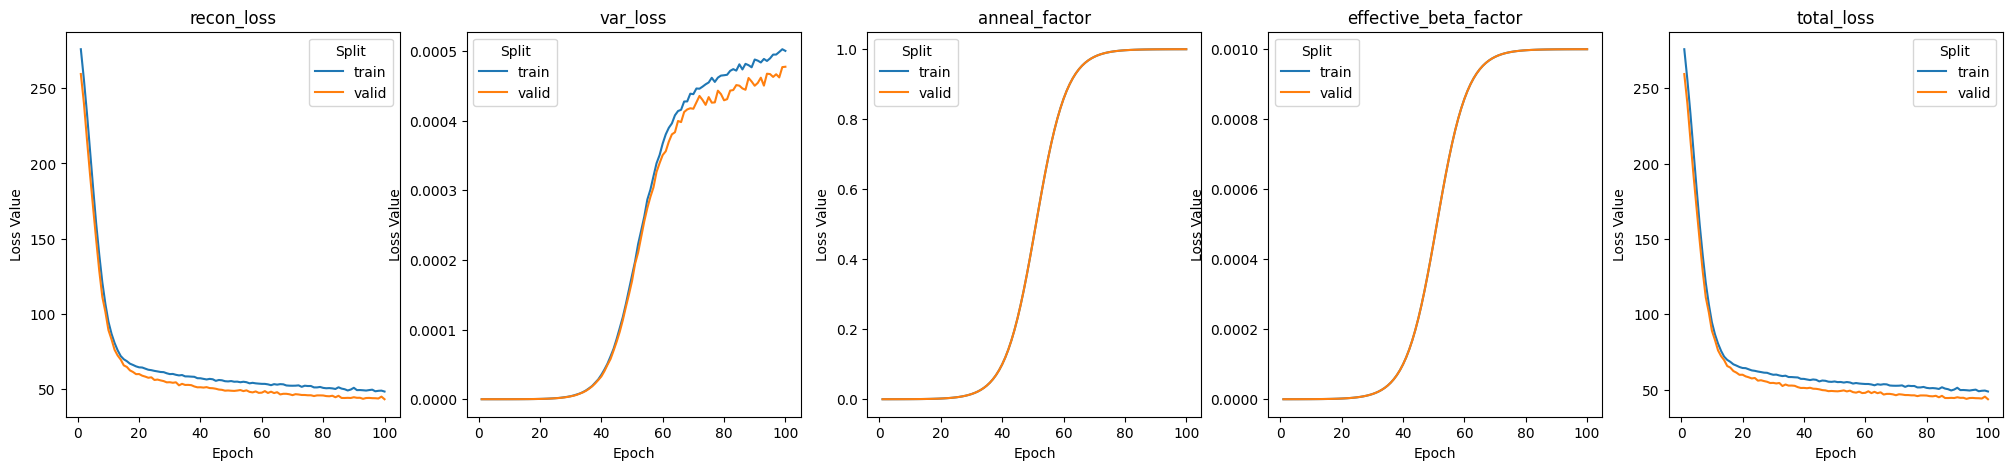

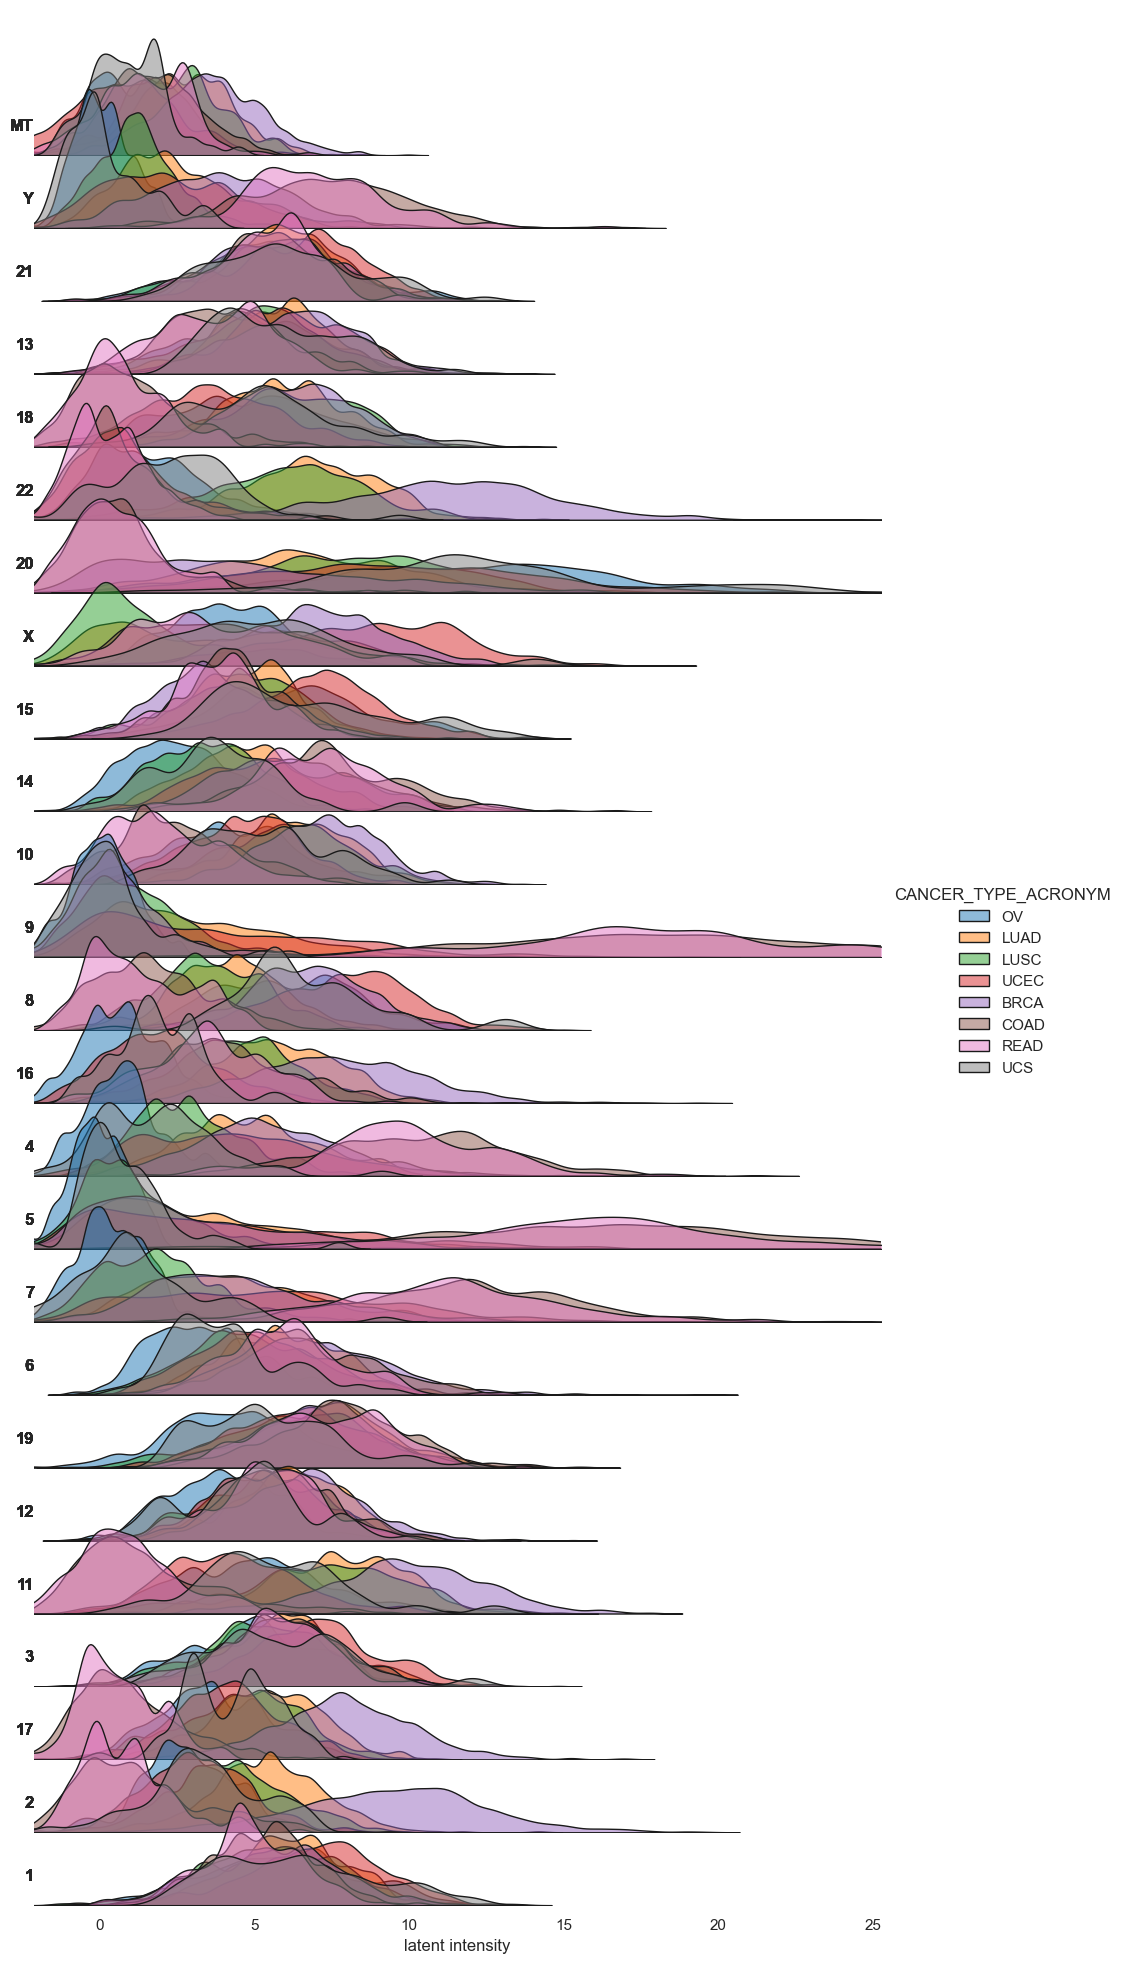

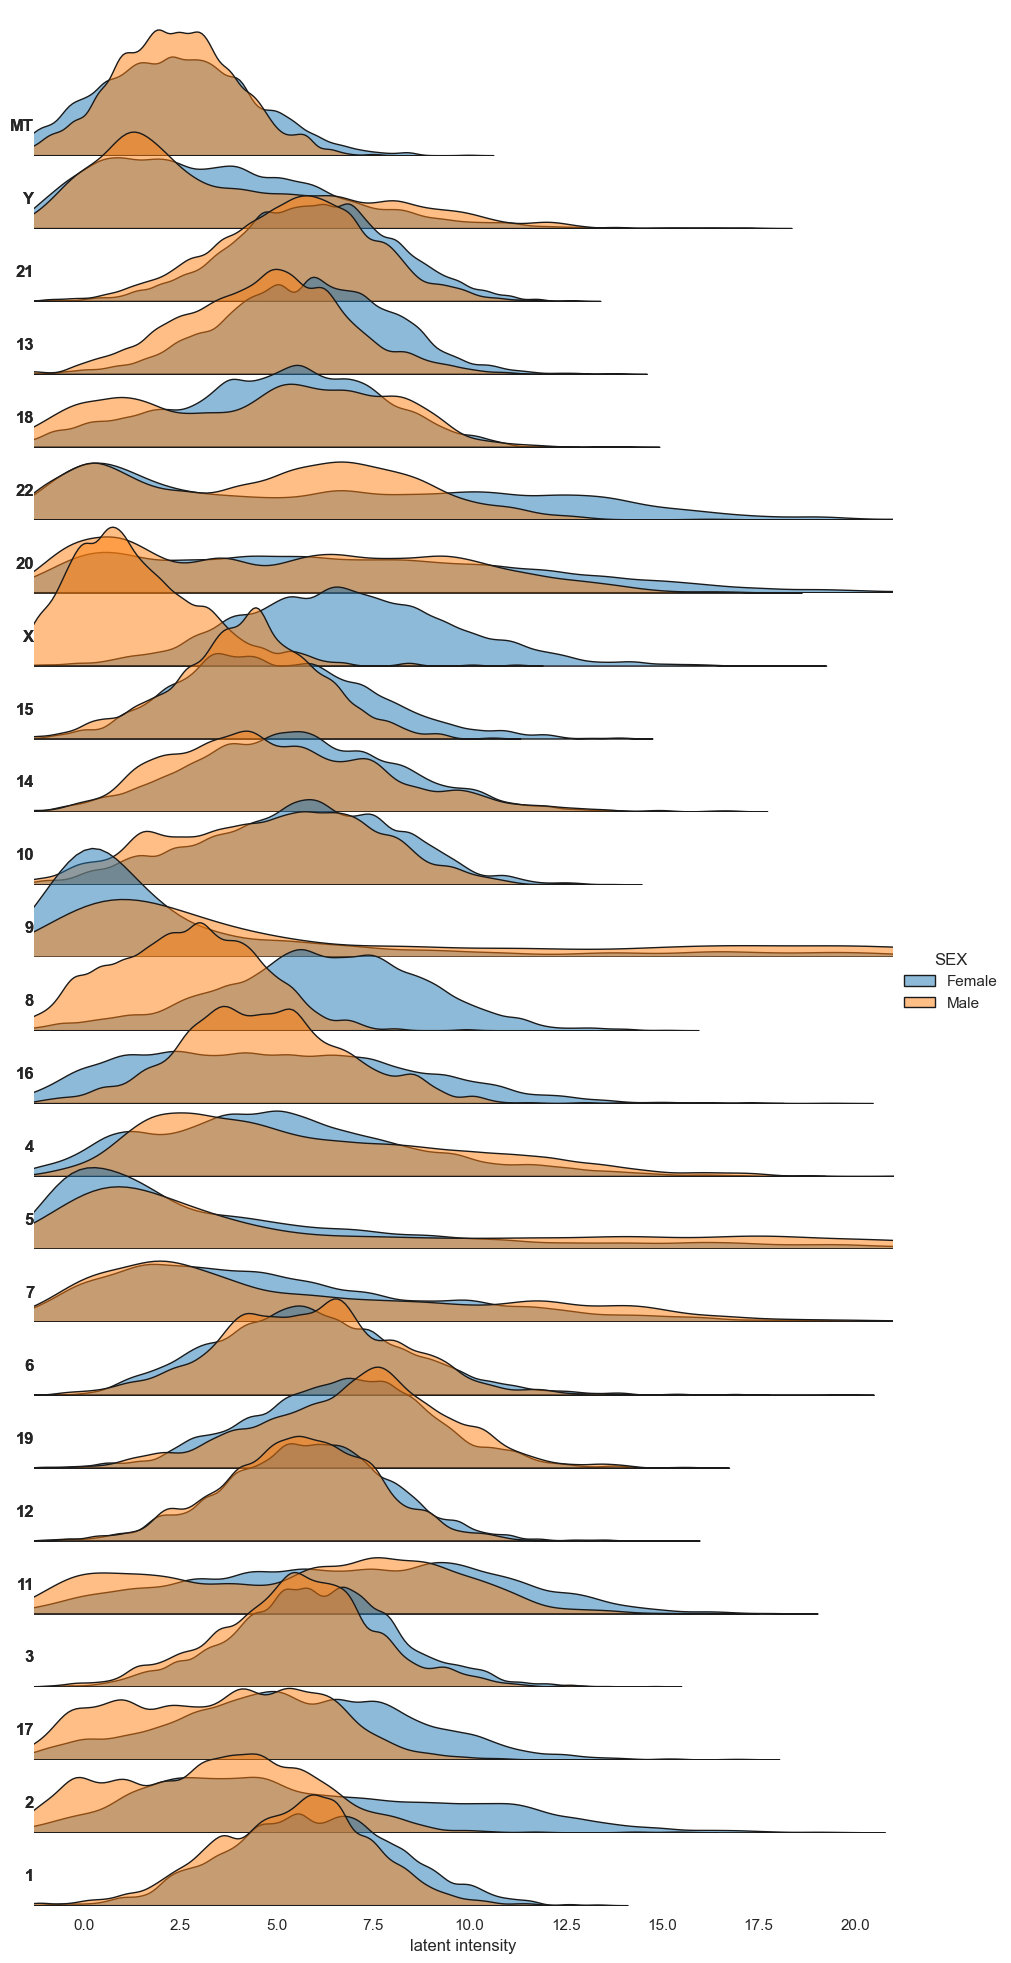

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


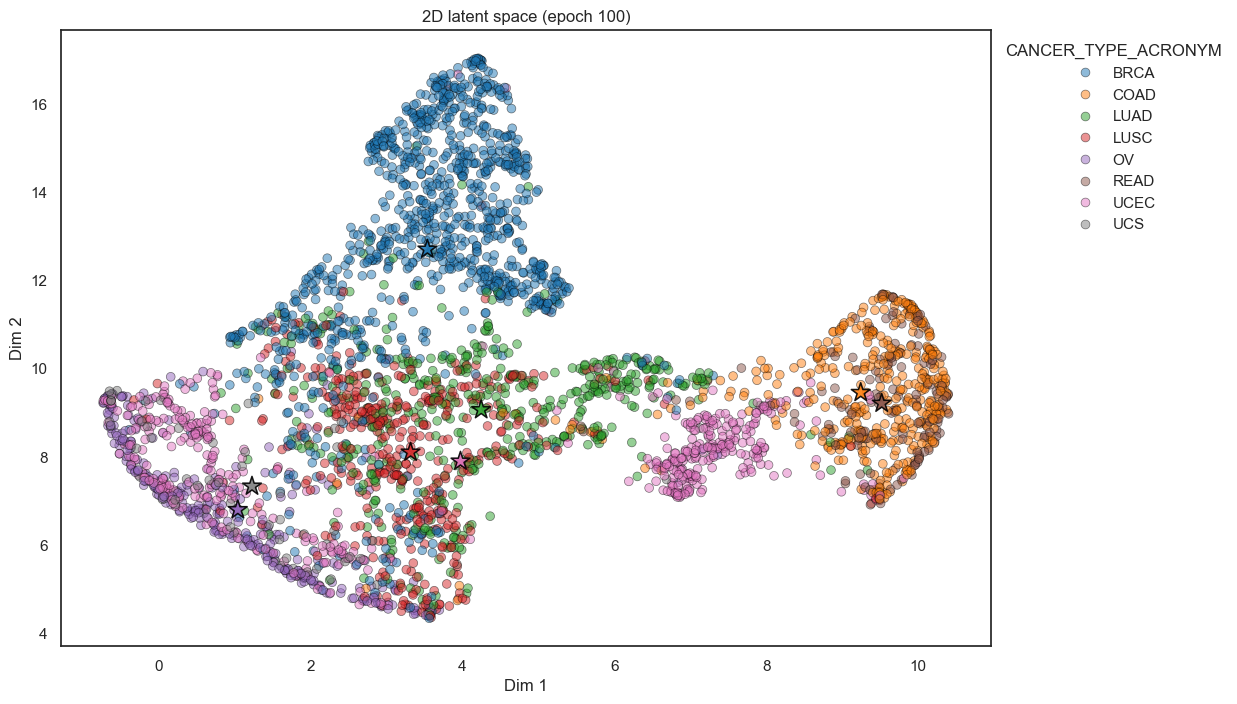

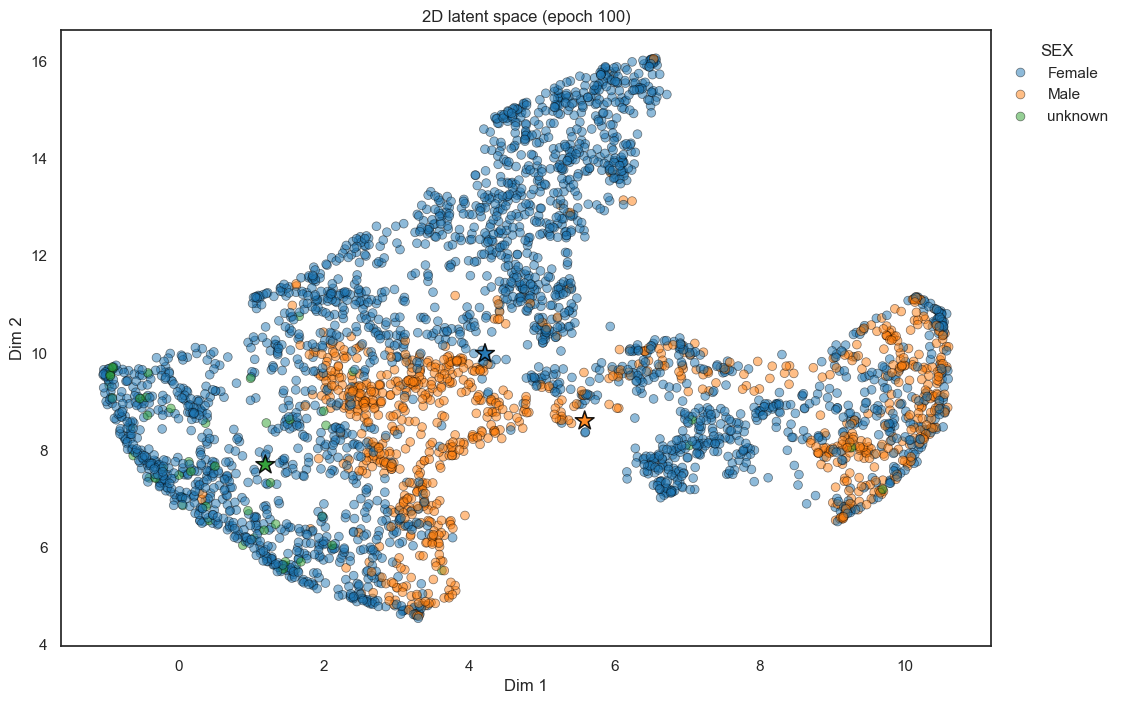

In [9]:
# ontix.show_result(params=["SEX"])
ontix.show_result()

In [10]:
ontix.evaluate()

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: CANCER_TYPE_ACRONYM
Perform ML task for target parameter: SEX


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x32da647f0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x32da66d40>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x32da64730>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 707 × 25
    uns: 'var_names'
final_reconstruction: No

## 2) Set-up Ontology and Initialize Pipeline with Reactome Pathways
Chromosomal location as ontology is mostly a proof of concept as shown above how to gain explainability of latent dimensions.  
In practice, something like biological pathways or gene ontology is most commonly used to gain biological insights. 

In [11]:
reactome_genelevel = "full_ont_lvl1_reactome.txt"
reactome_hiddenlevel = "full_ont_lvl2_reactome_named.txt"
ont_files = [reactome_hiddenlevel, reactome_genelevel]
ont_files = [os.path.join(data_root, f) for f in ont_files]
ontix_react = acx.Ontix(ontologies=ont_files, config=ontix_config)

In [12]:
result = ontix_react.run()

reading parquet: data/raw/combined_rnaseq_formatted.parquet
reading parquet: data/raw/combined_meth_formatted.parquet
reading parquet: data/raw/combined_clin_formatted.parquet
anno key: paired
Features in feature_order not found in all_feature_names: ['100133144', '100134869', '10357', '10431', '155060', '388795', '390284', '57714', '645851', '653553', '729884', '8225', '90288', '87769', '144568', '729522', '79719', '80755', '132949', '9625', '79963', '650655', '150000', '653190', '730013', '55324', '83451', '145447', '84945', '25864', '116236', '84696', '11057', '79575', '51225', '25890', '29777', '80325', '25841', '9744', '23527', '116983', '84680', '57001', '52', '53', '92370', '84519', '93953', '56', '81569', '57180', '653857', '64431', '90', '97', '98', '161931', '10863', '203102', '8755', '27299', '55803', '105', '57143', '90956', '79934', '203054', '22850', '23394', '141', '113622', '165', '64782', '60312', '134265', '84632', '246182', '4299', '2334', '3899', '172', '54812', '38

#### Gaining Insights by Visualizing Latent Dimensions
In comparison to other pipelines, `Ontix` has interpretable latent dimensions as shown in the plots below:


Creating plots ...


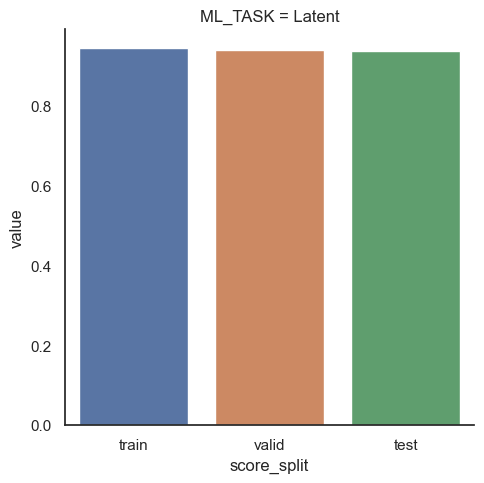

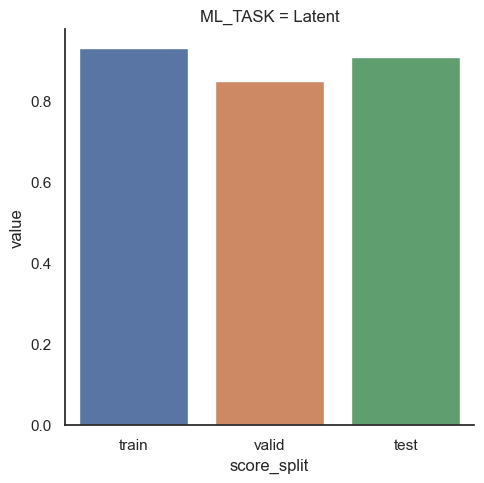

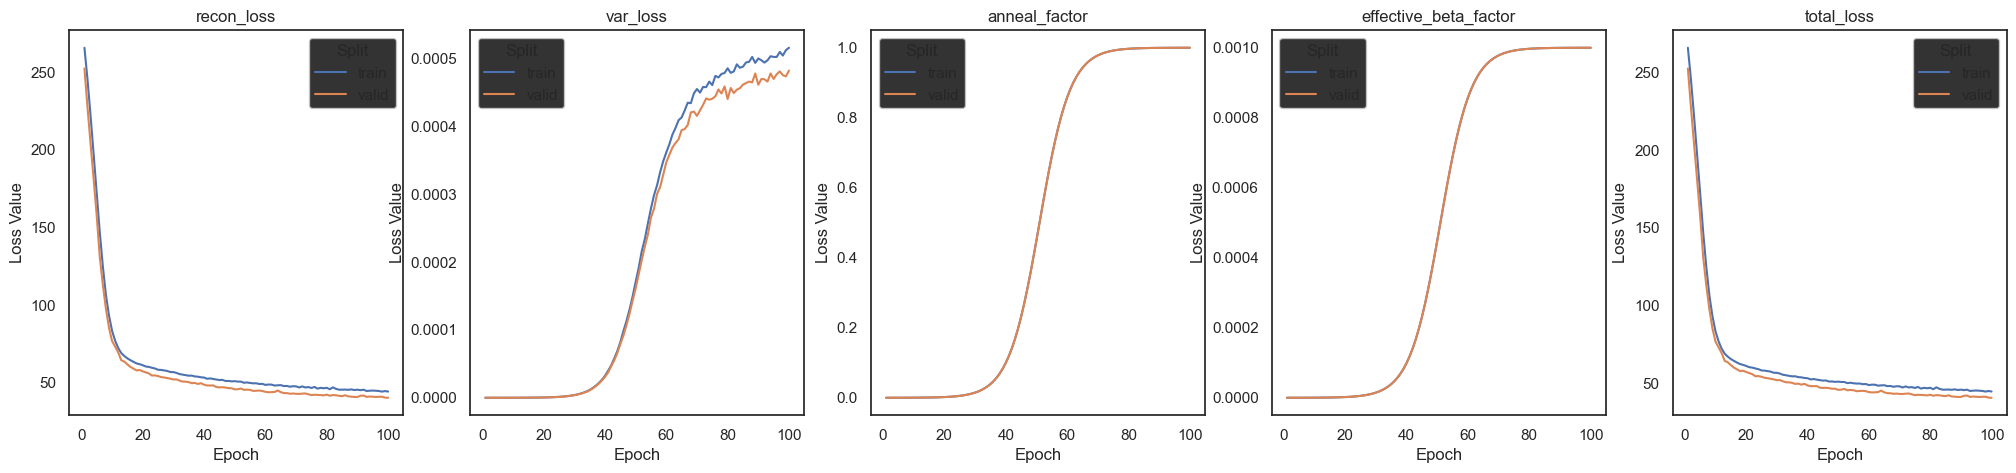

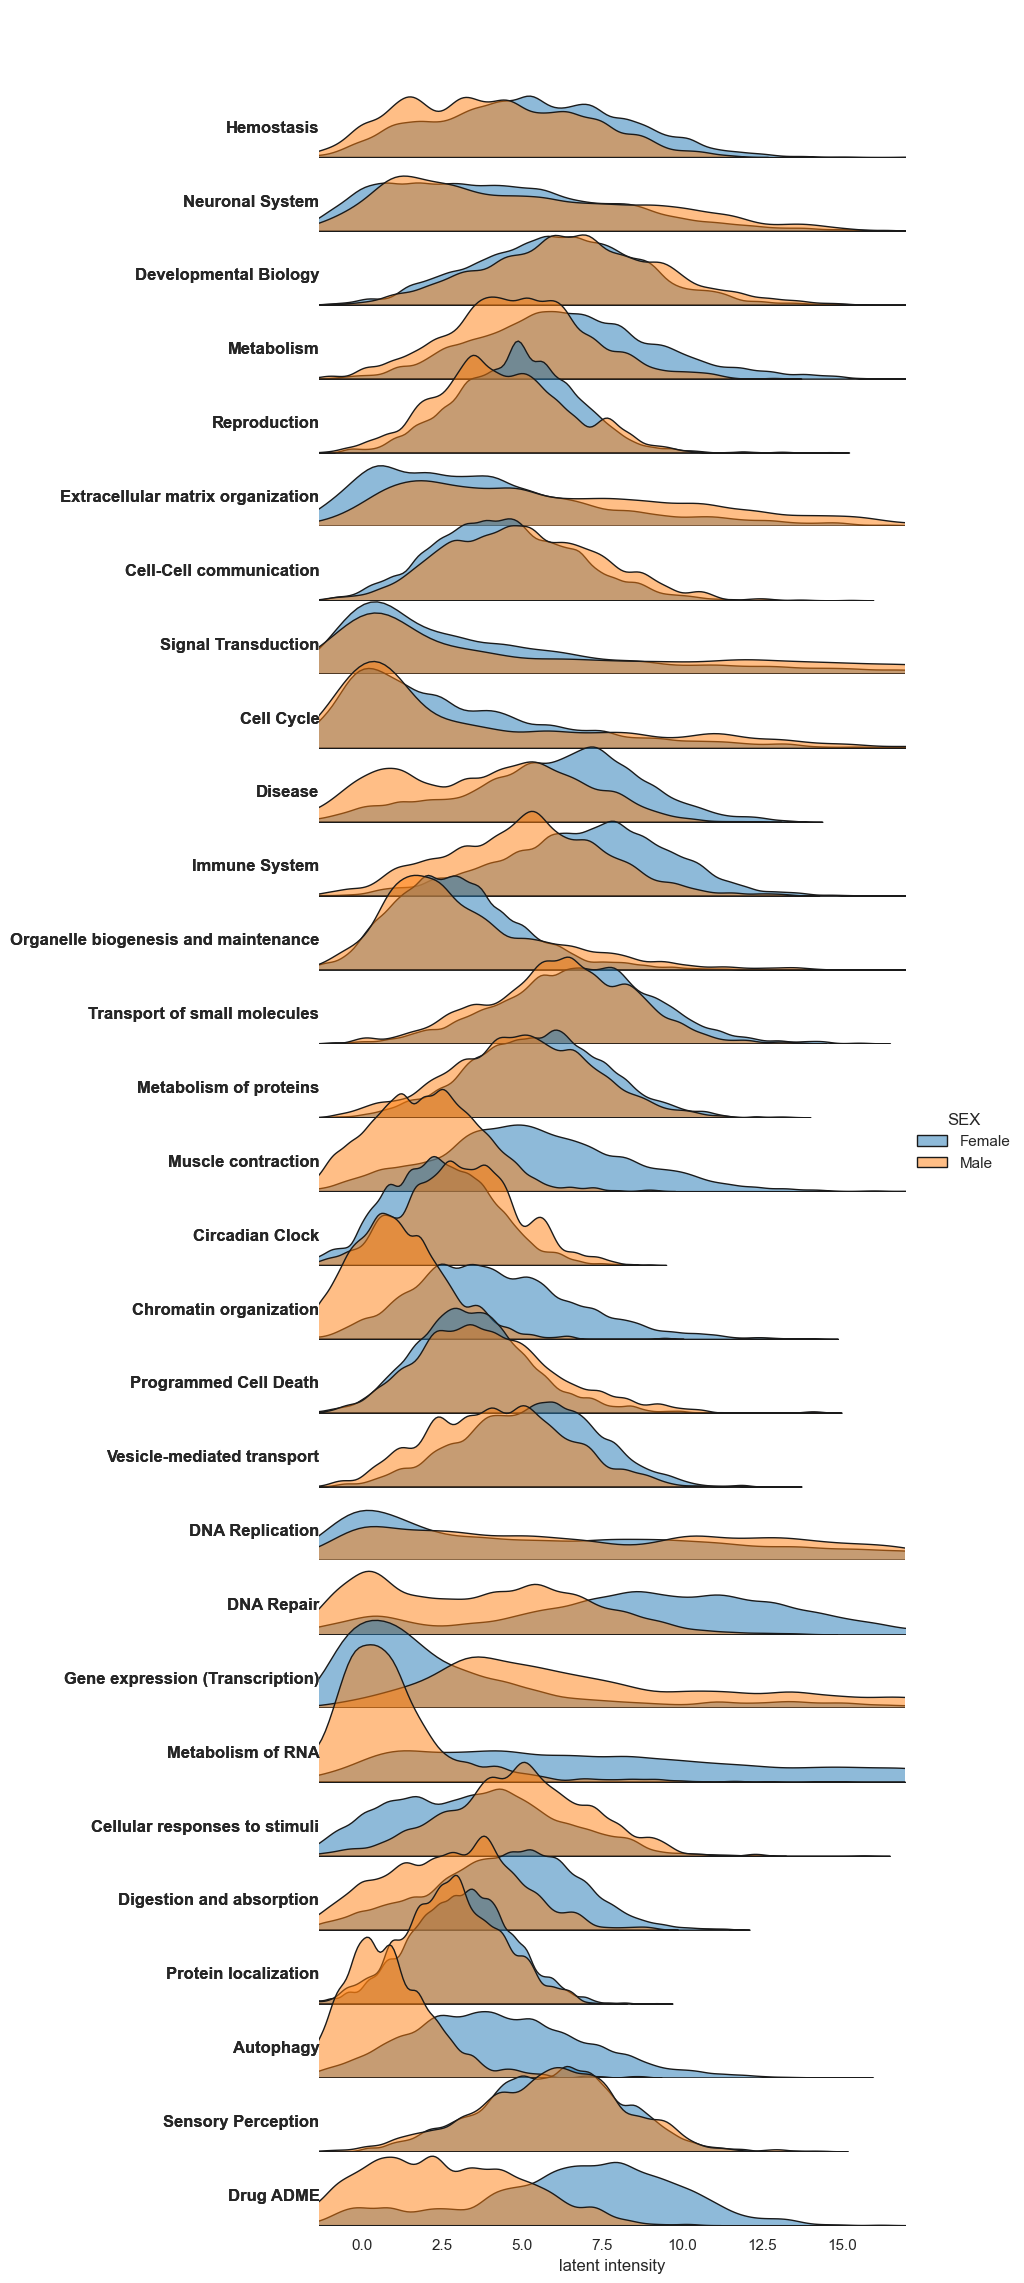

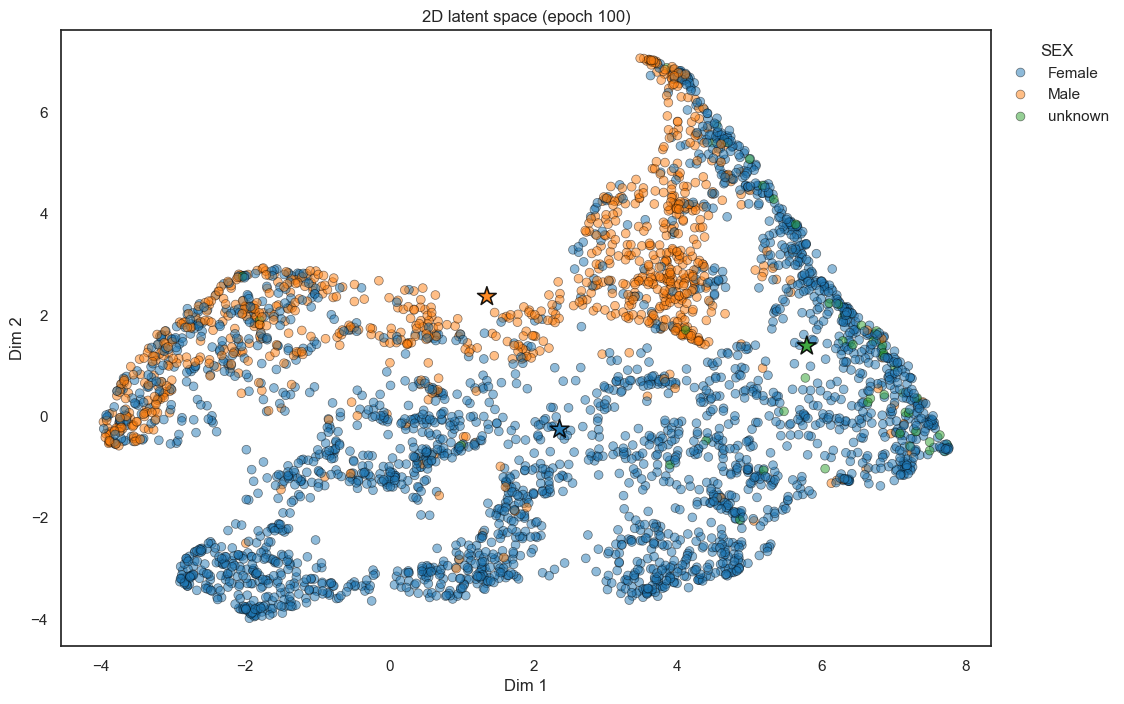

In [13]:
ontix_react.show_result(params=["SEX"])

#### Obtain Results
If we're interested in working with latent spaces, reconstructions, or losses, we can access these for `Ontix` as for any other pipeline. For more details see `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`.


In [14]:
print(f"The following results are saved: {list(r.__dict__.keys())}")
train_loss = r.losses.get(split="train", epoch=20)

print(f"Loss at epoch 20 for split train was: {train_loss}")
ls = r.latentspaces.get(split="test", epoch=-1)
ls


The following results are saved: ['latentspaces', 'sample_ids', 'reconstructions', 'mus', 'sigmas', 'losses', 'sub_losses', 'preprocessed_data', 'model', 'model_checkpoints', 'datasets', 'new_datasets', 'adata_latent', 'final_reconstruction', 'sub_results', 'sub_reconstructions', 'embedding_evaluation']
Loss at epoch 20 for split train was: 64.17686742867535


array([[ 1.9215679 ,  0.22379304,  4.715747  , ...,  3.7905421 ,
         2.5823193 ,  2.9603984 ],
       [ 1.7434766 ,  1.0892545 ,  5.1814885 , ...,  4.0644298 ,
         2.38277   ,  5.1757407 ],
       [ 0.9432234 , -1.2186447 ,  3.8818932 , ...,  1.7931093 ,
         1.8140087 ,  2.8140693 ],
       ...,
       [ 3.2356358 ,  4.394729  ,  4.4952955 , ...,  8.343848  ,
         9.817456  ,  4.6083336 ],
       [-0.9978477 , -0.39864367,  7.0629387 , ...,  2.634243  ,
         4.013674  ,  6.928536  ],
       [ 5.306647  ,  5.845952  ,  6.737702  , ..., 10.15626   ,
        10.84177   ,  7.375119  ]], shape=(707, 25), dtype=float32)

#### Save Ontix
Like all other pipelines we can save, load and re-use `Ontix` as shown below:

In [15]:

import os
import glob

outpath = os.path.join("tutorial_res", "ontix.pkl")
ontix.save(file_path=outpath, save_all=True)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
ontix_loaded = acx.Ontix.load(outpath)

Preprocessor saved successfully.
Pipeline object saved successfully.
PKL files: ['tutorial_res/imagix.pkl', 'tutorial_res/imagix_preprocessor.pkl']
Model files: ['tutorial_res/imagix_model.pth']
Attempting to load a pipeline from tutorial_res/ontix.pkl...
Pipeline object loaded successfully. Actual type: Ontix
Preprocessor loaded successfully.


Creating plots ...


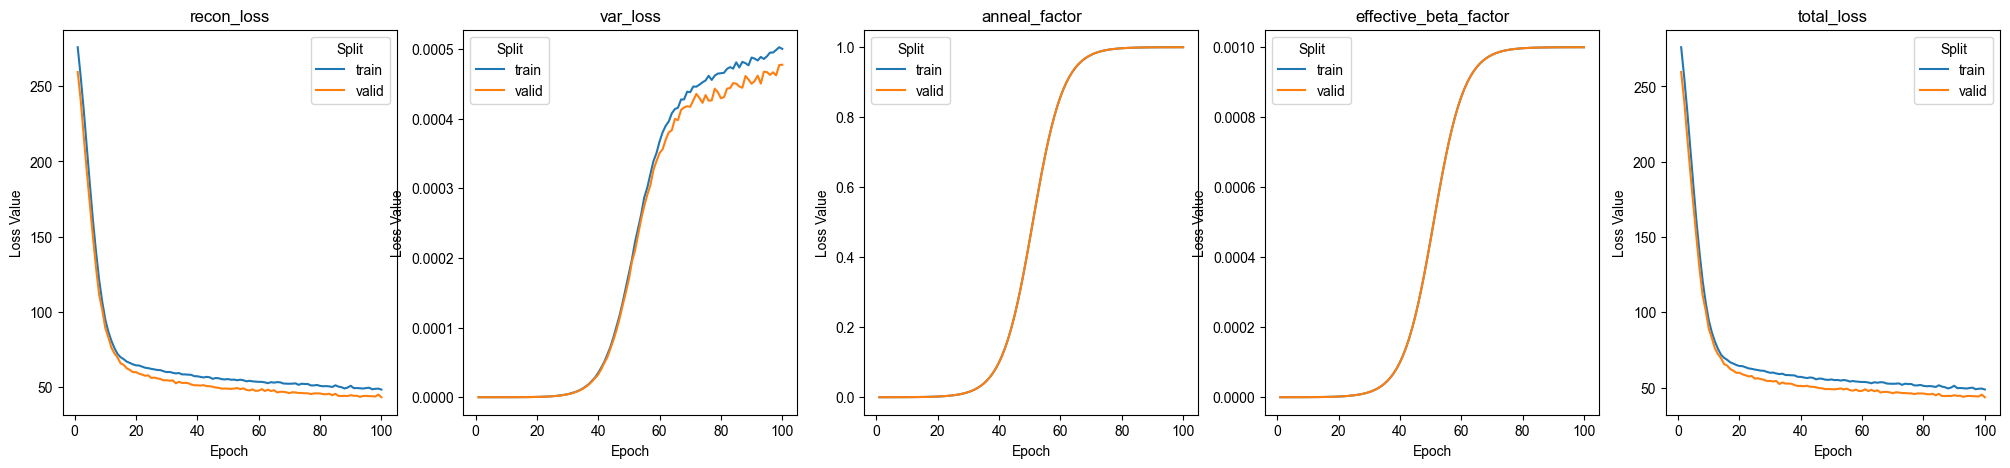

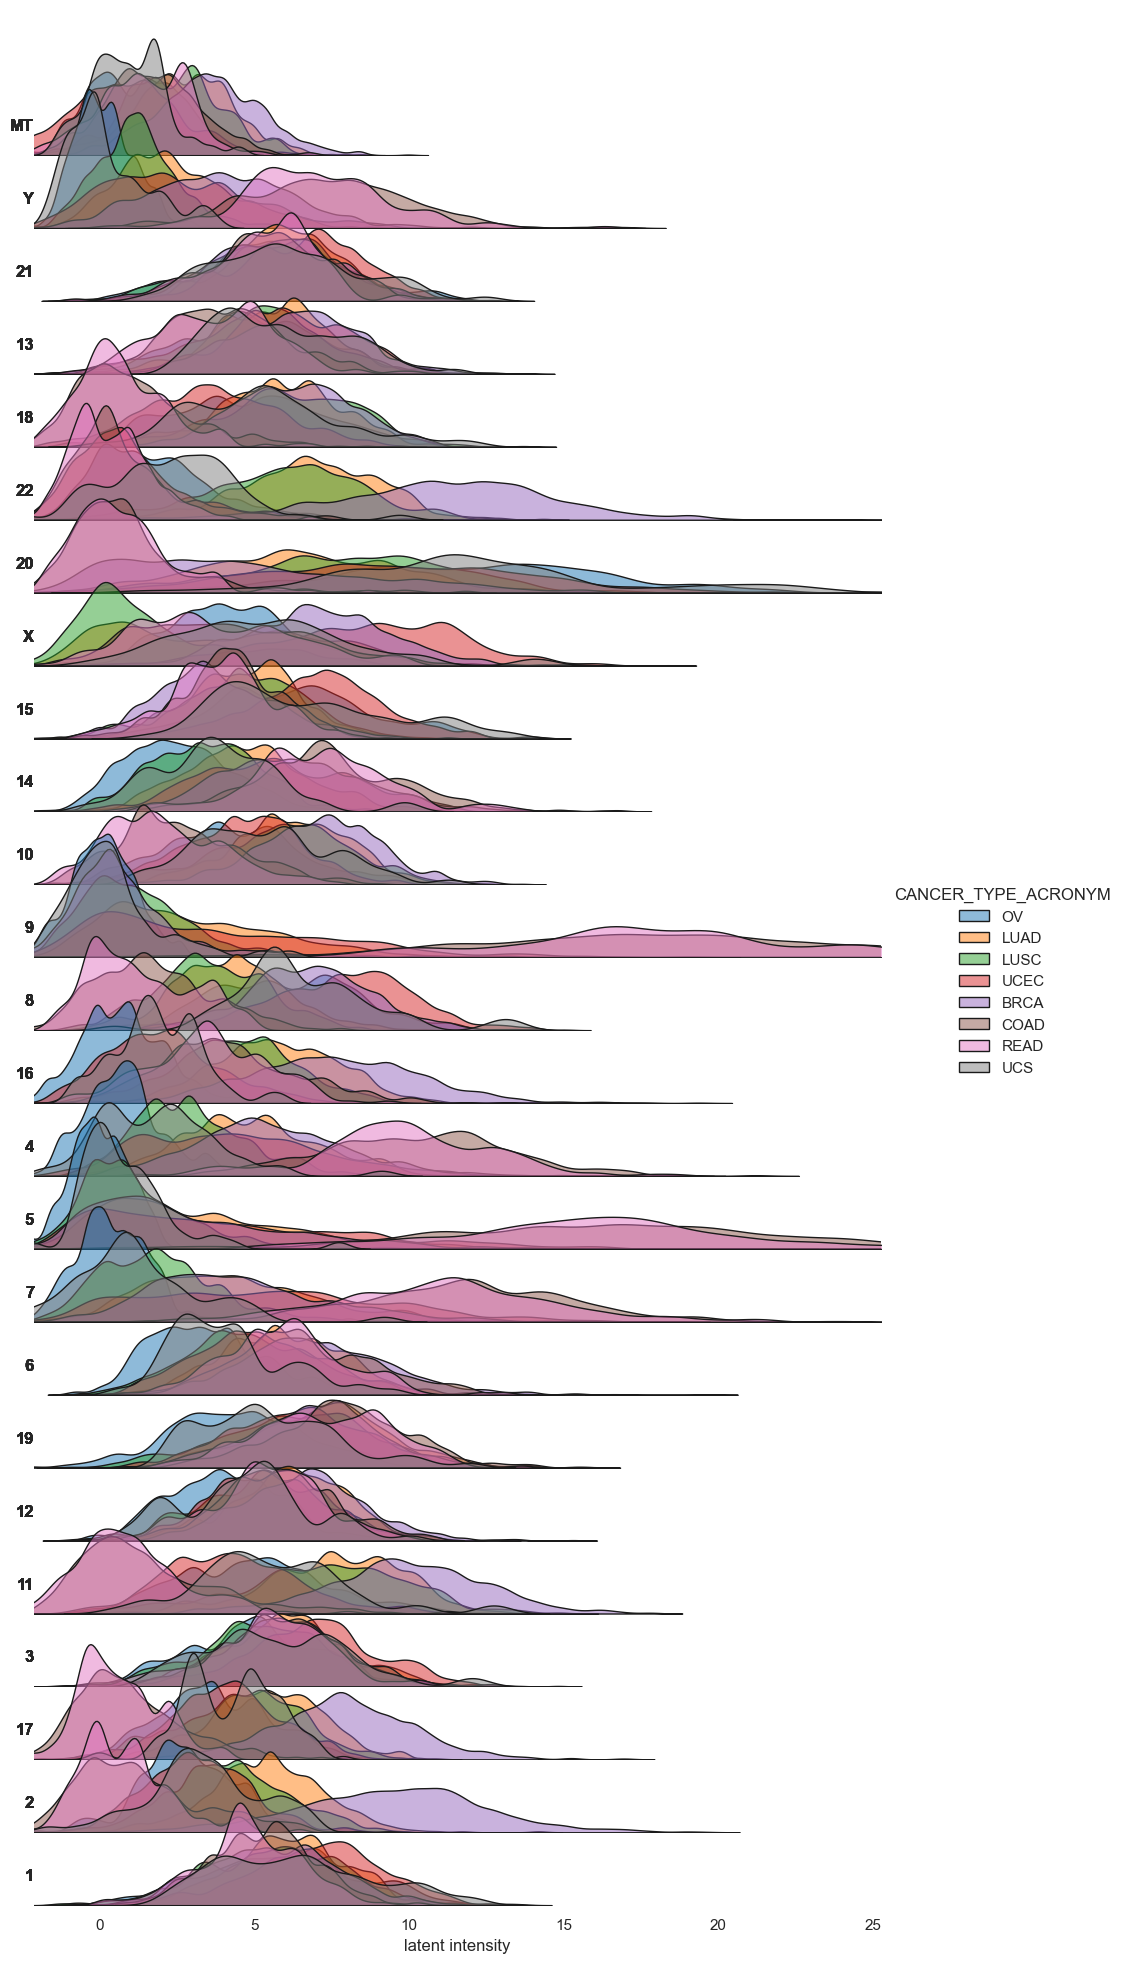

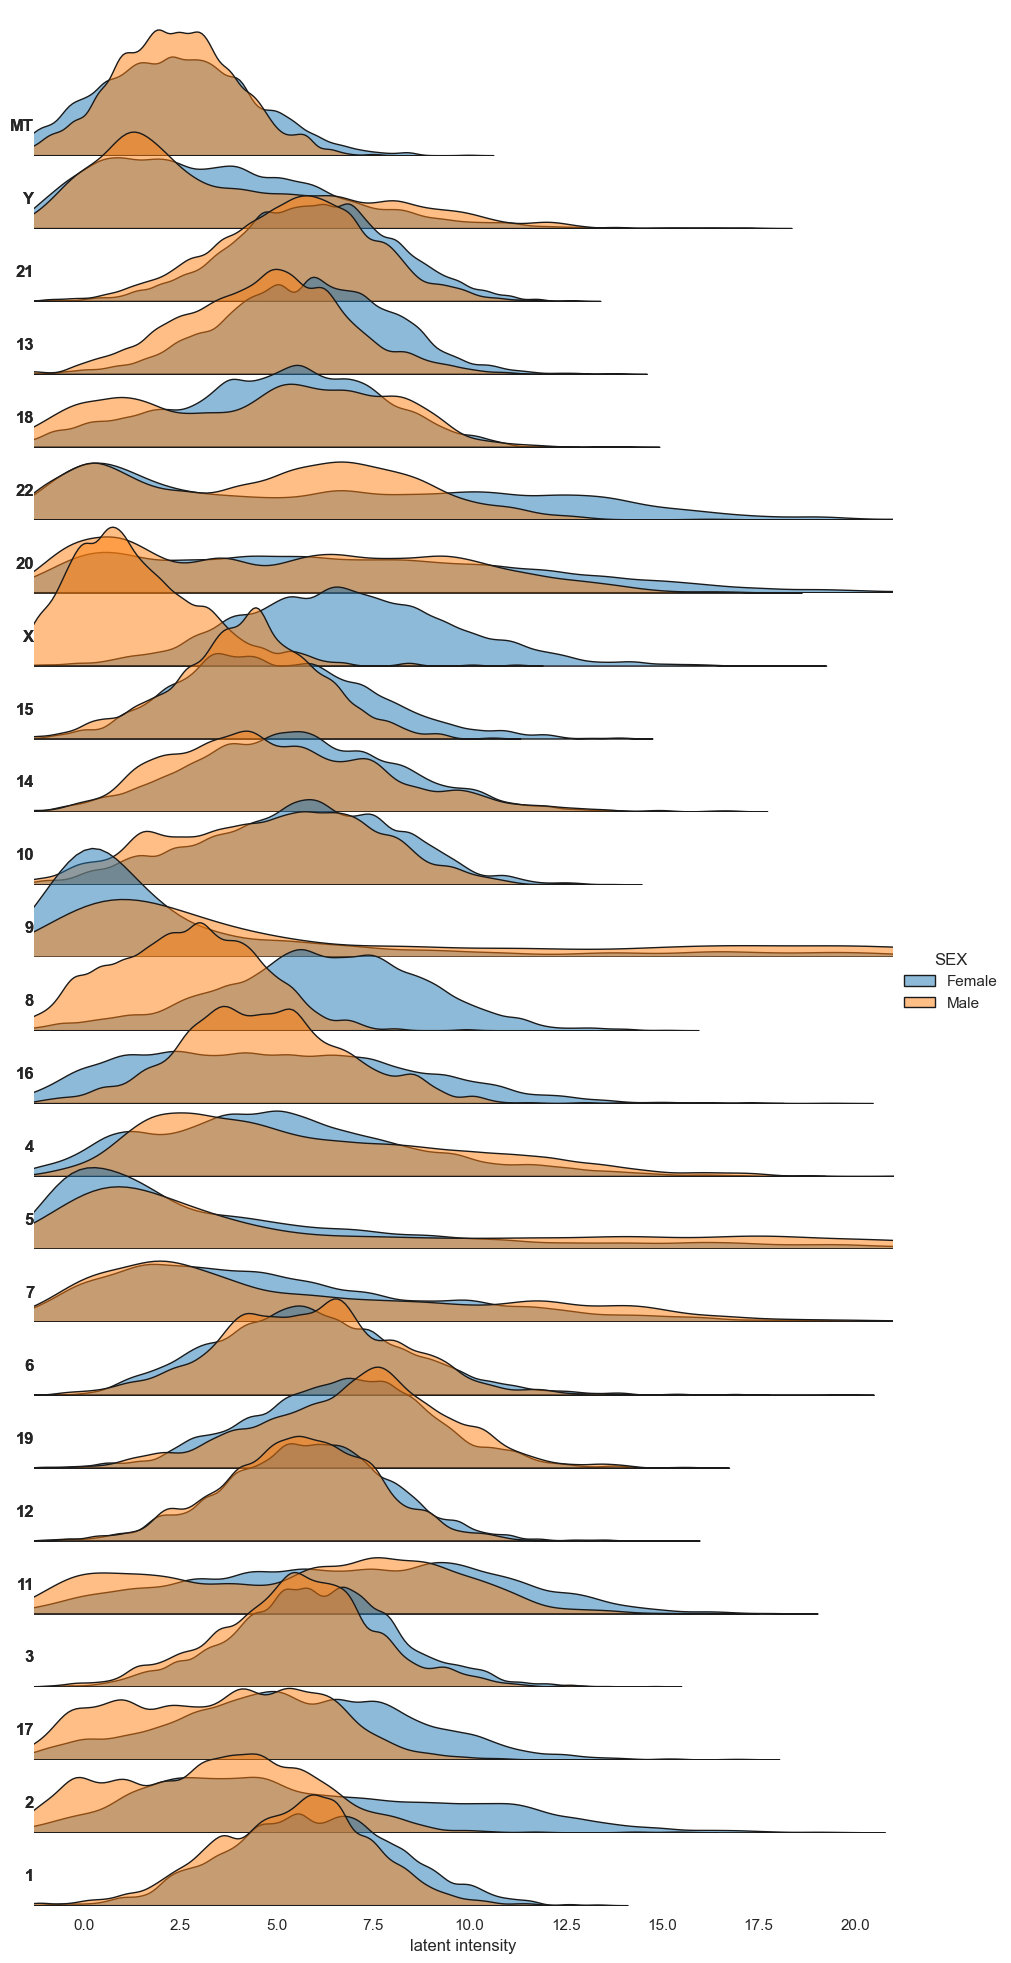

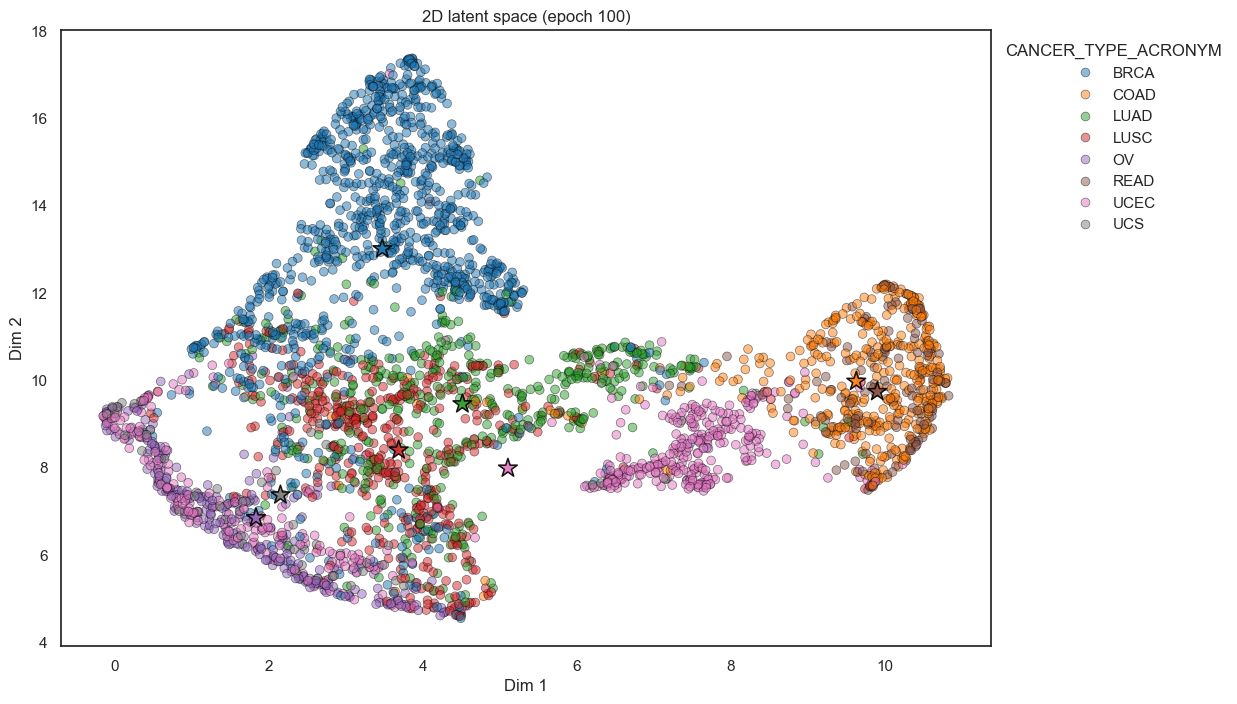

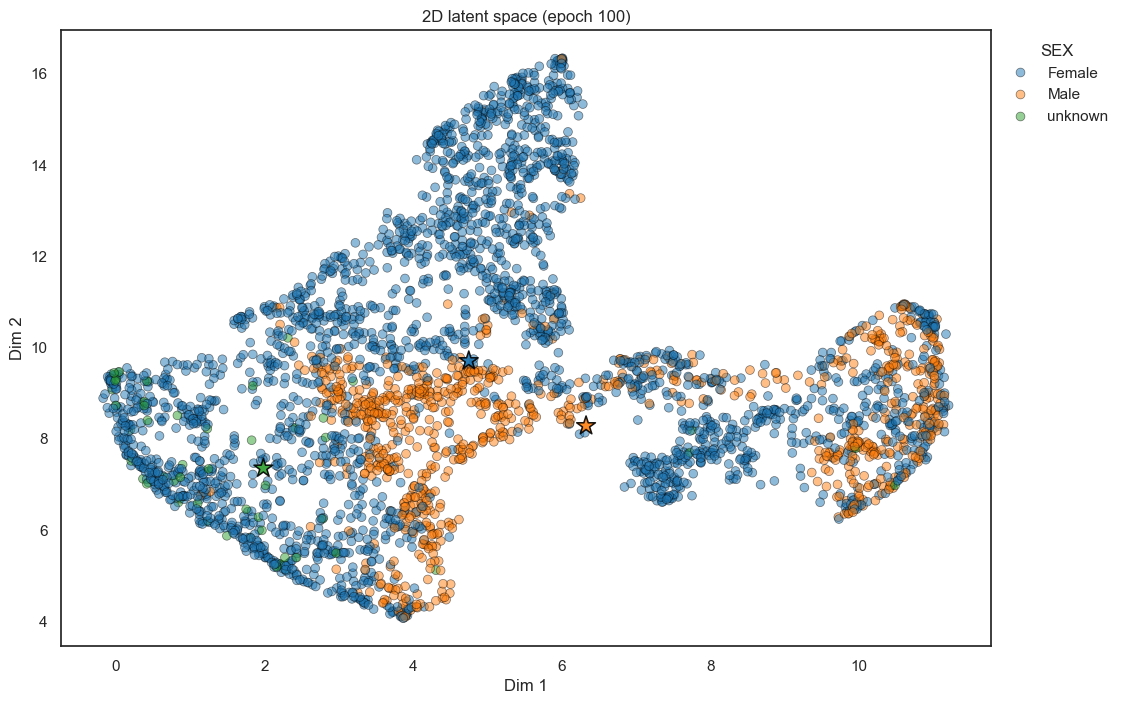

In [16]:
ontix_loaded.show_result()

In [17]:

test = ontix_react.result.datasets
ontix_react.save(file_path=os.path.join("tutorial_res", "ontix_reactome.pkl"))
ontix_react_loaded = acx.Ontix.load(os.path.join("tutorial_res", "ontix_reactome.pkl"))
ontix_react_loaded.predict(data=test)

Preprocessor saved successfully.
saving memory efficient
Ontix checks:
All possible feature names length: 11308
Feature order length: 2000
Feature names without filtering: 2000
Mask layer 0 with shape torch.Size([638, 29]) and 641.0 connections
Mask layer 1 with shape torch.Size([2000, 638]) and 12126.0 connections
Latent Dim: 29
Pipeline object saved successfully.
Attempting to load a pipeline from tutorial_res/ontix_reactome.pkl...
Pipeline object loaded successfully. Actual type: Ontix
Preprocessor loaded successfully.


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=None, valid=None, test=None)
new_datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3e539bfa0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3d1bfd8d0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3d1bc91b0>)
adata_latent: AnnData object with n_obs × n_vars = 707 × 29
    uns: 'var_names'
final_reconstruction: None
sub_results: None
sub_reconstructions: None
embedding_evaluation: Empty DataFrame
Columns: []
Index: []


#### Generate New Data
For a variational autoencoder, the generate or sample_latent_space step draws new latent vectors from the model’s learned latent distribution.

**Latent Sampling:** 
The model first aggregates the posterior over all encoded latent vectors in the chosen split and epoch by computing the mean (global_mu) and log-variance (global_logvar). It then samples new latent points from a diagonal Gaussian defined by these aggregate statistics, using the reparameterization trick to inject Gaussian noise.

**Number of Samples (n_samples):** 
Users can specify how many latent points to generate. The method expands the aggregated mean and log-variance to match the requested number of samples before sampling.

**Custom Latent Prior:** 
Optionally, a custom latent_prior can be provided (a tensor or NumPy array with shape (n_samples, latent_dim)), which will be used directly instead of the aggregated posterior. This is basically the `decode` step.


In [18]:
generated_reconstructions = ontix_react_loaded.generate(n_samples=5)
print(generated_reconstructions)

tensor([[0.0422, 0.0598, 0.0039,  ..., 0.3654, 0.3339, 0.6647],
        [0.0478, 0.0594, 0.0024,  ..., 0.3806, 0.3323, 0.6240],
        [0.0443, 0.0580, 0.0035,  ..., 0.3528, 0.3108, 0.6923],
        [0.0494, 0.0598, 0.0018,  ..., 0.3823, 0.3223, 0.6265],
        [0.0436, 0.0585, 0.0018,  ..., 0.3789, 0.3582, 0.6854]],
       device='mps:0')


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:1175: UserWarning: latent_prior has latent dimension 29, which matches the input feature dimension of the model. Did you mean to provide latent vectors of dimension For Ontix this is the default behaviour and the warning can be ignored. 6?
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:863: UserWarning: latent_prior has latent dimension 29, which matches the input feature dimension of the model. Did you mean to provide latent vectors of dimension For Ontix this is the default behaviour and the warning can be ignored. 6?
  warnings.warn(


## 3) Evaluate Ontix on Downstream Tasks
Coming Soon